# DAE solver

In this notebook, we show some examples of solving a DAE model. For the purposes of this example, we use the CasADi solver, but the syntax remains the same for other solvers

In [1]:
%pip install "pybamm[plot,cite]" -q    # install PyBaMM if it is not installed
import pybamm
import numpy as np
import os
import matplotlib.pyplot as plt
os.chdir(pybamm.__path__[0]+'/..')

You should consider upgrading via the '/home/mrobins/git/PyBaMM/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Integrating DAEs

In PyBaMM, a model is solved by calling a solver with solve. This sets up the model to be solved, and then calls the method `_integrate`, which is specific to each solver. We begin by setting up and discretising a model

In [2]:
# Create model
model = pybamm.BaseModel()
u = pybamm.Variable("u")
v = pybamm.Variable("v")
model.rhs = {u: -v} # du/dt = -v
model.algebraic = {v: 2 * u - v} # 2*v = u
model.initial_conditions = {u: 1, v: 2}
model.variables = {"u": u, "v": v}

# Discretise using default discretisation
disc = pybamm.Discretisation()
disc.process_model(model);

Now the model can be solved by calling `solver.solve` with a specific time vector at which to evaluate the solution

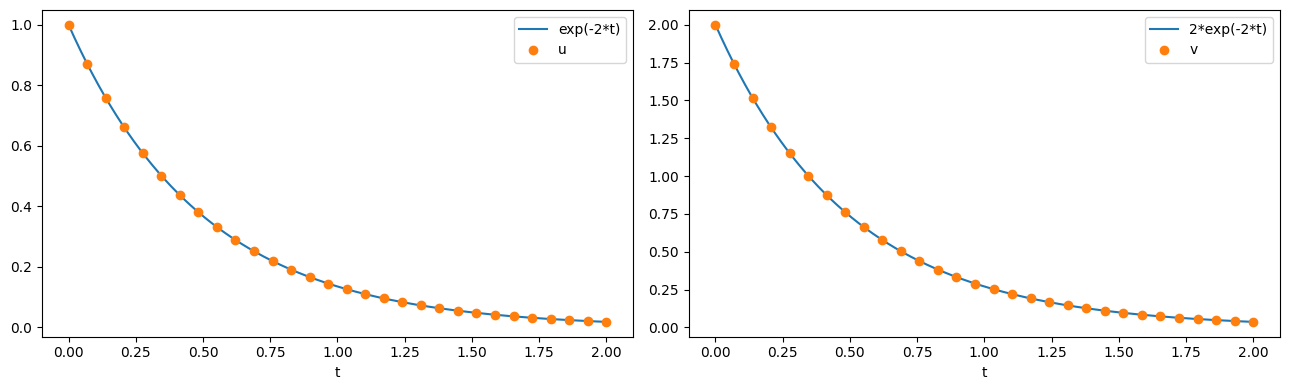

In [3]:
# Solve #################################
t_eval = np.linspace(0, 2, 30)
dae_solver = pybamm.CasadiSolver(mode="safe")
solution = dae_solver.solve(model, t_eval)
#########################################

# Extract u and v
t_sol = solution.t
u = solution["u"]
v = solution["v"]

# Plot
t_fine = np.linspace(0,t_eval[-1],1000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4))
ax1.plot(t_fine, np.exp(-2 * t_fine), t_sol, u(t_sol), "o")
ax1.set_xlabel("t")
ax1.legend(["exp(-2*t)", "u"], loc="best")

ax2.plot(t_fine, 2 * np.exp(-2 * t_fine), t_sol, v(t_sol), "o")
ax2.set_xlabel("t")
ax2.legend(["2*exp(-2*t)", "v"], loc="best")

plt.tight_layout()
plt.show()

Note that, where possible, the solver makes use of the mass matrix and jacobian for the model. However, the discretisation or solver will have created the mass matrix and jacobian algorithmically, using the expression tree, so we do not need to calculate and input these manually.

The solution terminates at the final simulation time:

In [4]:
solution.termination

'final time'

### Events

It is possible to specify events at which a solution should terminate. This is done by adding events to the `model.events` dictionary. In the following example, we solve the same model as before but add a termination event when `v=-0.2`.

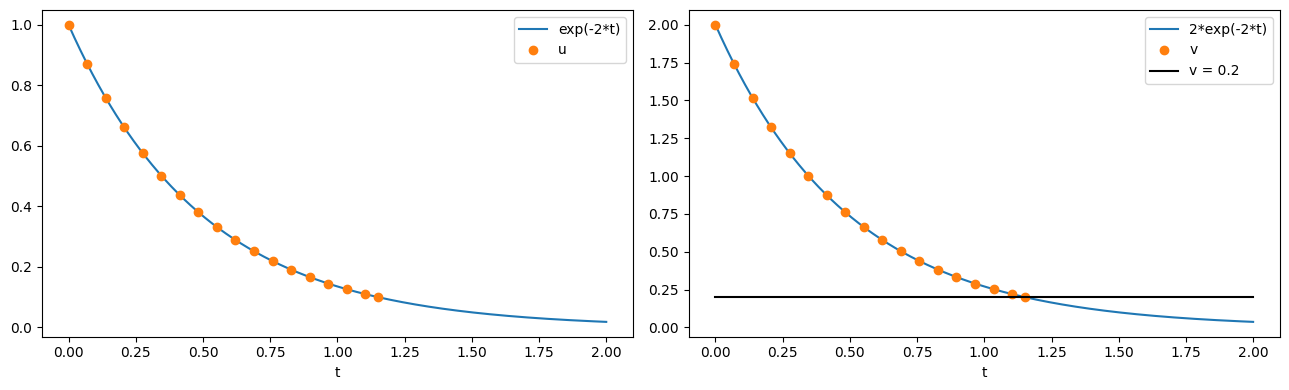

In [5]:
# Create model
model = pybamm.BaseModel()
u = pybamm.Variable("u")
v = pybamm.Variable("v")
model.rhs = {u: -v} # du/dt = -v
model.algebraic = {v: 2 * u - v} # 2*v = u
model.initial_conditions = {u: 1, v: 2}
model.events.append(pybamm.Event('v=0.2', v - 0.2)) # adding event here

model.variables = {"u": u, "v": v}

# Discretise using default discretisation
disc = pybamm.Discretisation()
disc.process_model(model)

# Solve #################################
t_eval = np.linspace(0, 2, 30)
dae_solver = pybamm.CasadiSolver(mode="safe")
solution = dae_solver.solve(model, t_eval)
#########################################

# Extract u and v
t_sol = solution.t
u = solution["u"]
v = solution["v"]

# Plot
t_fine = np.linspace(0,t_eval[-1],1000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4))
ax1.plot(t_fine, np.exp(-2 * t_fine), t_sol, u(t_sol), "o")
ax1.set_xlabel("t")
ax1.legend(["exp(-2*t)", "u"], loc="best")

ax2.plot(t_fine, 2 * np.exp(-2 * t_fine), t_sol, v(t_sol), "o", t_fine, 0.2 * np.ones_like(t_fine), "k")
ax2.set_xlabel("t")
ax2.legend(["2*exp(-2*t)", "v", "v = 0.2"], loc="best")

plt.tight_layout()
plt.show()

Now the solution terminates because the event has been reached

In [6]:
solution.termination

'event: v=0.2'

## Finding consistent initial conditions

The solver will fail if initial conditions that are inconsistent with the algebraic equations are provided. However, before solving the DAE solvers automatically use `_set_initial_conditions` to obtain consistent initial conditions, starting from a guess of bad initial conditions, using a simple root-finding algorithm. 

In [7]:
# Create model
model = pybamm.BaseModel()
u = pybamm.Variable("u")
v = pybamm.Variable("v")
model.rhs = {u: -v} # du/dt = -v
model.algebraic = {v: 2 * u - v} # 2*v = u
model.initial_conditions = {u: 1, v: 1} # bad initial conditions, solver fixes
model.events.append(pybamm.Event('v=0.2', v - 0.2))
model.variables = {"u": u, "v": v}

# Discretise using default discretisation
disc = pybamm.Discretisation()
disc.process_model(model)
print(f"y0_guess={model.concatenated_initial_conditions.evaluate().flatten()}")

dae_solver = pybamm.CasadiSolver(mode="safe")
dae_solver.set_up(model)
dae_solver._set_initial_conditions(model, 0, {}, True)
print(f"y0_fixed={model.y0}")

y0_guess=[1. 1.]
y0_fixed=[1, 2]


## References

The relevant papers for this notebook are:

In [8]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(7825):357–362, 2020. doi:10.1038/s41586-020-2649-2.
[3] Valentin Sulzer, Scott G. Marquis, Robert Timms, Martin Robinson, and S. Jon Chapman. Python Battery Mathematical Modelling (PyBaMM). Journal of Open Research Software, 9(1):14, 2021. doi:10.5334/jors.309.

